# Adaptive Directed Transfer Function 



**Definition:**

The Adaptive Directed Transfer Function (ADTF) is a time-varying extension of the Directed Transfer Function (DTF), used to estimate dynamic causal interactions among multivariate time series. It is based on adaptive multivariate autoregressive (AMVAR) modeling, where the coefficients of the MVAR model evolve over time to capture non-stationary behavior in brain signals.

**Mathematical Basis:**
1. At each time point 𝑡 and frequency 𝑓, a transfer matrix 𝐻(𝑡,𝑓) is derived from the AMVAR model. 

$$
H(t,f) = \left[I - \sum_{i=1}^h A_i(t) e^{-j2\pi f i} \right]^{-1}
$$

2. Calculate normalized ADTF values:
The resulting matrix represents the information transfer ratio from the j-th input to the i-th output.

$$
\gamma_{ij}(t, f) = \frac{\left| H_{ij}(t, f) \right|^2}{\sum_{m=1}^{k} \left| H_{im}(t, f) \right|^2}
$$

3. The integrated ADTF values were then computed by summing across the frequency bands of interest:

$$
\Theta_{ij}(t) = \int_{f_1}^{f_2} \gamma_{ij}(t, f) \, df
$$

**The value ranges from 0 to 1:**

- **0**: No causal influence from node *j* to *i* at frequency *f*, time *t*.
- **1**: Node *j* is the **sole source** driving node *i* at that frequency and time.

## 1. Compute Transfer Matrix in Frequency Domain

In [23]:
## Author: Hanwei Liu (violalhw@gmail.com)
## Date: 2025-04-09

import numpy as np

def transfer_matrix(A, f):
    """
    Computes the transfer matrix H for a VAR model with time point t and frequency f.

    Args:
        A (np.ndarray): Coefficient matrix with shape (T, p, n, n) or (p, n, n)
        f (float): Frequency 
        
    Notes:
        T: the number of coefficient matrix, T >= 1 indicates the number of segments or time periods. 
        p: the order of model or lags, p.shape = h-1
        n: nodes or channels of signal source, n >= 2

    Returns:
        H (np.ndarray): Transfer matrix H with shape (T, n, n) or (1, n, n)
    """
    
    if not isinstance(A, np.ndarray) or A.ndim not in (3, 4):
        raise ValueError("Coefficient Matrix A must be a 3D or 4D NumPy array")

    if A.ndim == 3:
        A = A[np.newaxis, ...]  # Convert to 4D: (1, p, n, n)

    T, p, n, _ = A.shape
    z_powers = np.exp(-1j * 2 * np.pi * f * np.arange(1, p + 1))  # shape: (p,)
    H = np.empty((T, n, n), dtype=complex)

    for t in range(T):
        A_sum = sum(A[t, k] * z_powers[k] for k in range(p))
        H[t] = np.linalg.inv(np.eye(n) - A_sum)

    # return H if H.shape[0] > 1 else H[0]
    return H 

    
    

## 2. Compute Normalized ADTF

In [35]:
def ADTF_matrix(H):
    """
    Compute the normalized Amplitude of the Directed Transfer Function (ADTF)
    from the transfer matrix H in the spectral domain.

    Args:
        H (np.ndarray): Transfer matrix of shape (T, n, n), where T >= 1

    Returns:
        np.ndarray: Normalized ADTF matrix of shape (T, n, n)
    """
    H_abs2 = np.abs(H) ** 2  # (T, n, n)
    row_sums = H_abs2.sum(axis=2, keepdims=True)  # (T, n, 1)

    # Avoid division by zero by setting zero denominators to 1 temporarily
    row_sums_safe = np.where(row_sums == 0, 1, row_sums)
    ADTF = H_abs2 / row_sums_safe

    # Set rows with original zero sum to zero
    # ADTF[row_sums == 0] = 0
    ADTF = np.where(row_sums == 0, 0, ADTF)

    return ADTF

def DTF_matrix(H):
    DTF = np.sqrt(ADTF_matrix(H))
    return DTF
                    
    

## 3. Compute Integrated ADTF

In [17]:
def integrate_ADTF(A, freqs):
    """
    Compute the frequency-integrated ADTF over a range of frequencies using the trapezoidal rule.

    Args:
        A (np.ndarray): VAR coefficient matrix of shape (T, p, n, n), while T >= 1
        freqs (np.ndarray): 1D array of frequency points to integrate over (e.g., np.linspace(0, 0.5, N))

    Returns:
        np.ndarray: Integrated ADTF matrix of shape (T, n, n)
    """
    if not isinstance(A, np.ndarray) or A.ndim not in (3, 4):
        raise ValueError("Coefficient matrix A must be a 3D or 4D NumPy array.")

    if not isinstance(freqs, (np.ndarray, list)) or len(freqs) == 0:
        raise ValueError("freqs must be a non-empty list or NumPy array.")

    if A.ndim == 3:
        A = A[np.newaxis, ...]

    T, p, n, _ = A.shape
    freqs = np.asarray(freqs)

    # Compute ADTF for all frequencies
    ADTF_all = np.stack([ADTF_matrix(transfer_matrix(A, f)) for f in freqs], axis=-1)  # shape: (T, n, n, n_freq)

    # Integrate along the frequency axis
    ADTF_integrated = np.trapz(ADTF_all, x=freqs, axis=-1)  # shape: (T, n, n)

    return ADTF_integrated if T > 1 else ADTF_integrated[0]


## 4. Simulation

### Example 1. Calculate ADTF

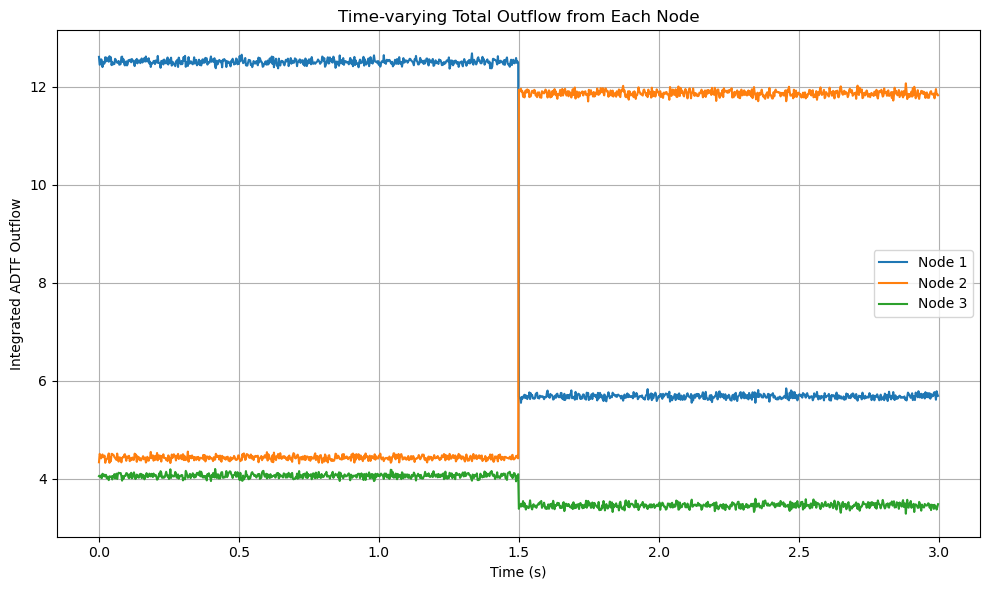

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Parameter Settings ---------------- #
# Model parameters
alpha21, beta21 = 0.9, 0.5
alpha31, alpha32 = 0.7, 0.4
gamma33 = 0.3
alpha12, beta12 = 0.8, 0.6

# Time and model dimensions
times = 3         # total duration in seconds
sfreq = 400       # sampling frequency in Hz
T = times * sfreq # total number of time points
p = 4             # order of the VAR model
n = 3             # number of nodes
A_coeffs = np.zeros((T, p, n, n))  # VAR coefficient matrix

# ---------------- Coefficient Assignment Functions ---------------- #
def assign_model_1(A, t):
    A[t, 0, 1, 0] = alpha21      # x1(t-1) → x2
    A[t, 3, 1, 0] = beta21       # x1(t-4) → x2
    A[t, 0, 2, 0] = alpha31      # x1(t-1) → x3
    A[t, 0, 2, 1] = alpha32      # x2(t-1) → x3
    A[t, 1, 2, 2] = gamma33      # x3(t-2) → x3

def assign_model_2(A, t):
    A[t, 0, 0, 1] = alpha12      # x2(t-1) → x1
    A[t, 3, 0, 1] = beta12       # x2(t-4) → x1
    A[t, 0, 2, 0] = alpha31      # x1(t-1) → x3
    A[t, 0, 2, 1] = alpha32      # x2(t-1) → x3
    A[t, 1, 2, 2] = gamma33      # x3(t-2) → x3

# ---------------- Assign Coefficients Over Time ---------------- #
for t in range(T):
    if t < T // 2:
        assign_model_1(A_coeffs, t)
    else:
        assign_model_2(A_coeffs, t)

# ---------------- Add Noise ---------------- #
np.random.seed(0)
noise = 0.01 * np.random.randn(*A_coeffs.shape)
A = A_coeffs + noise

# ---------------- Frequency Setup and ADTF Calculation ---------------- #
fmin, fmax, n_freqs = 3, 10, 100
freqs = np.linspace(fmin, fmax, n_freqs)

# Note: integrate_ADTF must be defined beforehand
Theta = integrate_ADTF(A, freqs)  # shape: (T, n, n)
node_outflow = np.sum(Theta, axis=1)     # total outflow from each node: (T, n)

# ---------------- Plotting ---------------- #
plt.figure(figsize=(10, 6))
time_sec = np.arange(T) / sfreq  # convert sample indices to seconds
for node in range(n):
    plt.plot(time_sec, node_outflow[:, node], label=f'Node {node+1}')

plt.xlabel("Time (s)")
plt.ylabel("Integrated ADTF Outflow")
plt.title("Time-varying Total Outflow from Each Node")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


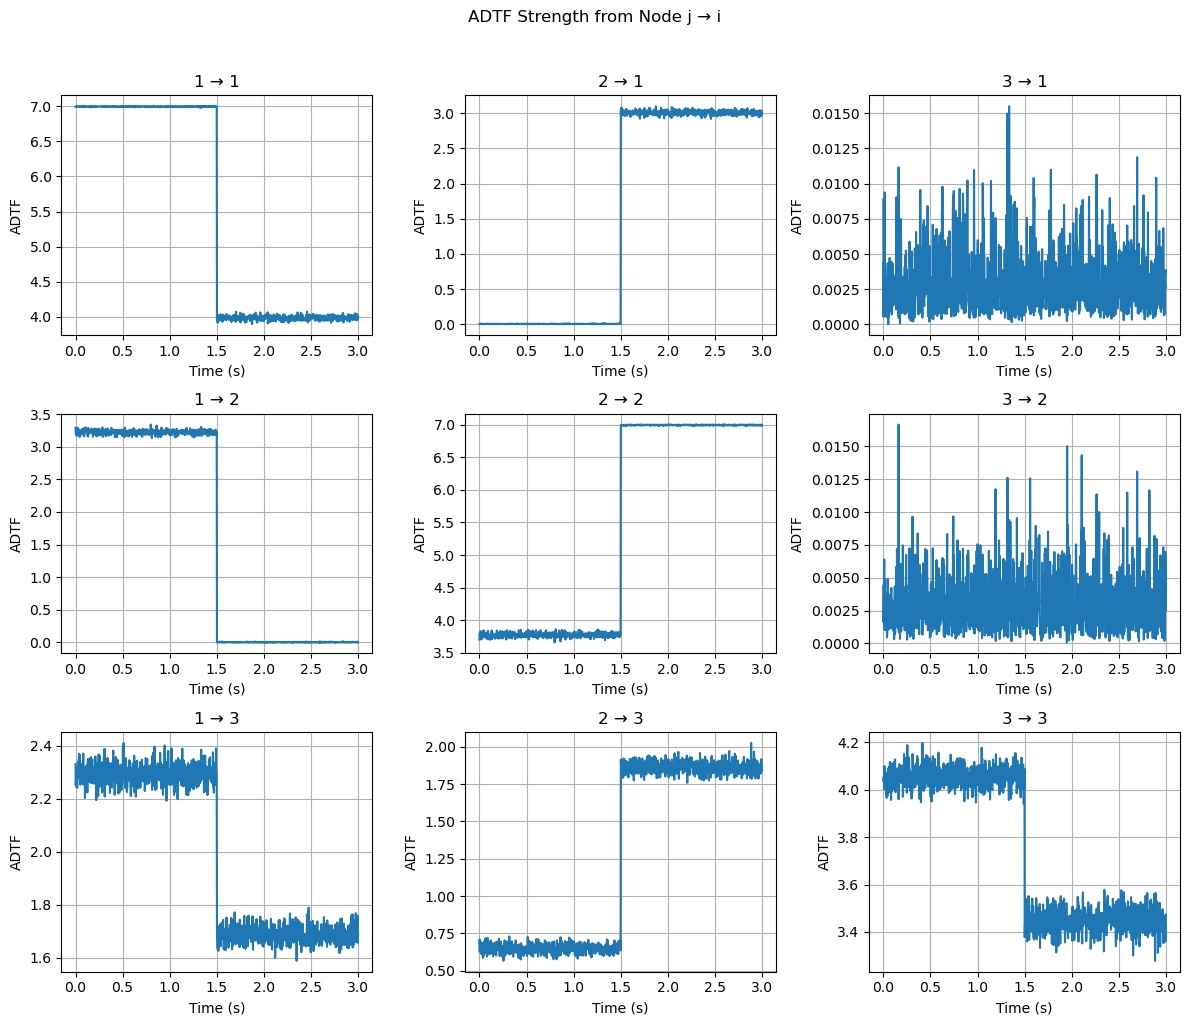

In [47]:
# Plot all node-to-node ADTF connections
fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # 3x3 subplot grid for 3 nodes

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        ax.plot(time_sec, Theta[:, i, j])
        ax.set_title(f"{j + 1} → {i + 1}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("ADTF")
        ax.grid(True)

fig.suptitle("ADTF Strength from Node j → i", y=1.02)
plt.tight_layout()
plt.savefig("adtf_all_connections.png", bbox_inches="tight")
plt.show()


### Example 2. Calculate DTF

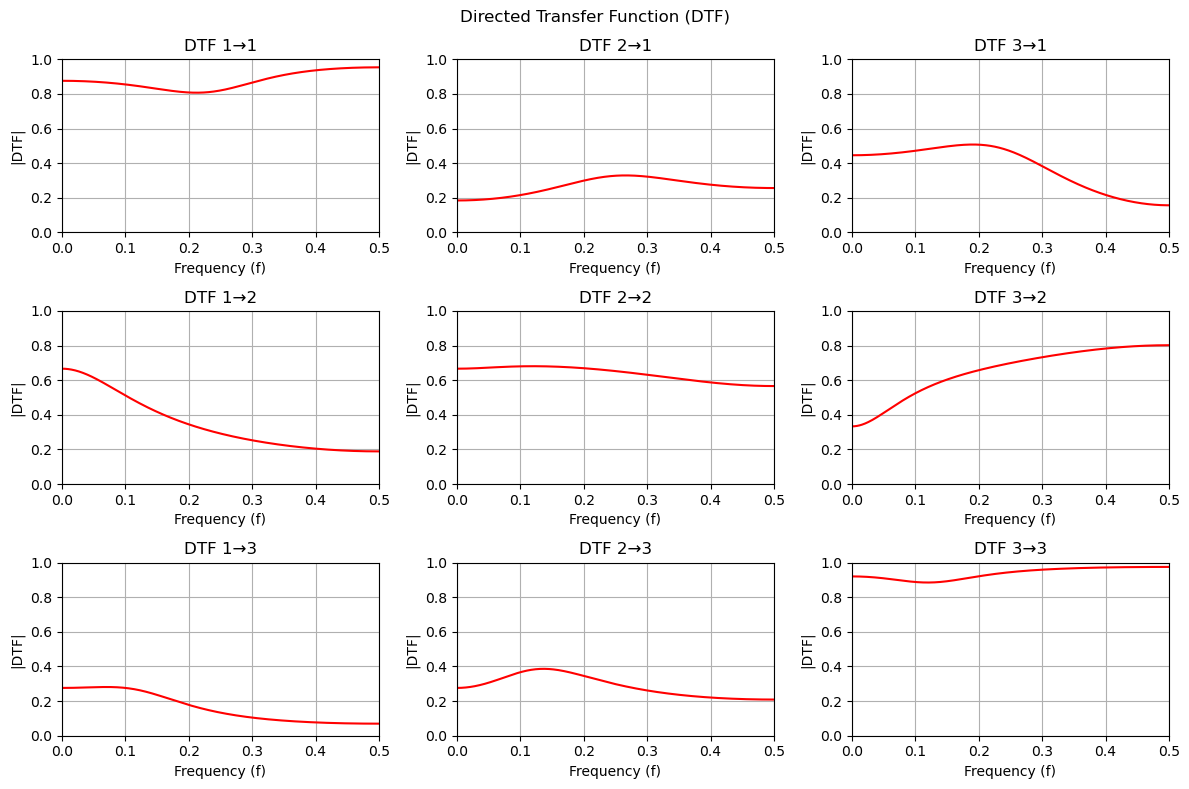

In [48]:
# Model order (p=1 for this example)
p = 1

A1 = np.random.rand(1, 1, 3, 3) 
# Coefficient matrix A_1 (3x3) for the MAR model (Equation 23)
A1[0] = np.array([
    [0.5, 0.3, 0.4],    
    [-0.5, 0.3, 1.0],   
    [0.0, -0.3, -0.2]   # no x1(n-1) term
])

# Frequency range (0 to 0.5, normalized)
freqs = np.linspace(0, 0.5, 500)
dtf_results = np.zeros((len(freqs), 3, 3))

# Compute DTF for all frequencies
for idx, f in enumerate(freqs):
    H_f = transfer_matrix(A1,f)
    dtf = DTF_matrix(H_f)
    dtf_results[idx] = dtf

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
plt.suptitle("Directed Transfer Function (DTF)")


for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(freqs, dtf_results[:, i, j], 'r')
        ax.set_xlabel("Frequency (f)")
        ax.set_ylabel("|DTF|")
        ax.set_title(f"DTF {j+1}→{i+1}")
        ax.set_xlim(0, 0.5)
        ax.set_ylim(0, 1)  # DTF is normalized between 0 and 1
        ax.grid(True)

plt.tight_layout()
plt.savefig("dtf_results.png", bbox_inches="tight")
plt.show()


In [37]:
# Verify key properties
# 1. Check if DTF_31 ≈ 0 (x1 has no direct effect on x3)
print("Max DTF_31:", np.max(dtf_results[:, 2, 0]))  # Should be near 0

# 2. Check normalization: sum(|DTF_ij|^2) = 1 for each row
for i in range(3):
    row_sum = np.sum(dtf_results[100, i, :]**2)  # Pick a frequency (e.g., index 100)
    print(f"Row {i+1} sum of squares at f={freqs[100]:.2f}: {row_sum:.4f}")

Max DTF_31: 0.2814802606070398
Row 1 sum of squares at f=0.10: 1.0000
Row 2 sum of squares at f=0.10: 1.0000
Row 3 sum of squares at f=0.10: 1.0000


## References

[[1]](https://ieeexplore.ieee.org/document/4353451) Wilke, C., Ding, L., & He, B. (2007, August). An adaptive directed transfer function approach for detecting dynamic causal interactions. In 2007 29th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (pp. 4949-4952). IEEE.

[[2]](https://link.springer.com/article/10.1007/pl00007990) Baccalá, L. A., & Sameshima, K. (2001). Partial directed coherence: a new concept in neural structure determination. Biological cybernetics, 84(6), 463-474.


